In [3]:
from glob import glob
import datetime

from astropy.table import Table
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.stats import spearmanr
import seaborn as sns
sns.set_style("whitegrid")

Why do this?

## Gather the data

### HR

+ redshift cut

In [8]:
HR = pd.read_csv('../data/CampbellHoltzman_mb.tsv', sep='\t', usecols=['SNID', 'redshift', 'hr', 'err_mu'], index_col='SNID')
HR.rename(columns={'err_mu': 'hr uncert'}, inplace=True)
HR = HR[HR['redshift']<0.2]
HR.describe()

,redshift,hr uncert,hr
count,110.000000,110.000000,110.000000
mean,0.143270,0.081345,0.033863
std,0.041233,0.021431,0.300665
min,0.045248,0.056201,-0.495474
25%,0.114008,0.065902,-0.148960
50%,0.151705,0.076867,-0.012910
75%,0.180152,0.088614,0.115199
max,0.198704,0.169502,1.377882


### SALT2 parameters (x_1 & c)

In [10]:
t = Table.read('../data/SDSS_Photometric_SNe_Ia.fits')
salt = t['CID','Z','X1','X1_ERR','COLOR','COLOR_ERR'].to_pandas()
salt.columns = salt.columns.str.lower()
salt.rename(columns={'cid': 'SNID', 'z': 'redshift'}, inplace=True)
salt.set_index('SNID', inplace=True)
salt.describe()

,redshift,x1,x1_err,color,color_err
count,752.000000,752.000000,752.000000,752.000000,752.000000
mean,0.294032,-0.006514,0.765859,-0.013105,0.059070
std,0.103553,1.082517,0.506811,0.100019,0.023878
min,0.037069,-2.952440,0.061210,-0.245912,0.024959
25%,0.220188,-0.776738,0.426394,-0.084207,0.041157
50%,0.294489,0.022410,0.702974,-0.019256,0.055565
75%,0.369411,0.793196,1.011968,0.051200,0.073263
max,0.700345,2.887440,8.048070,0.246569,0.195758


### Stellar Mass

In [16]:
galaxy = pd.read_csv('../resources/kcorrect_stellarmass.csv',  usecols=['GAL', 'redshift', 'stellarmass'], index_col='GAL')
galaxy.rename(columns={'redshift': 'gal redshift', 'stellarmass': 'stellar mass'}, inplace=True)
galaxy.describe()

,gal redshift,stellar mass
count,306.000000,3.060000e+02
mean,0.223114,4.163392e+10
std,0.072936,5.003677e+10
min,0.000000,5.926090e+02
25%,0.175192,8.166742e+09
50%,0.236245,2.331775e+10
75%,0.283725,5.782568e+10
max,0.336325,3.486340e+11


### Age

In [13]:
age = pd.read_csv('../resources/ages_campbell.tsv', sep='\t',  skiprows=[1],
                   usecols=['# sn id', 'age'], dtype={'age': np.float64, '# sn id': np.int})
age.rename(columns={'# sn id': 'SNID'}, inplace=True)
age.set_index('SNID', inplace=True)
age.describe()

,age
count,300.000000
mean,4.918252
std,1.953591
min,1.442631
25%,3.385100
50%,4.609988
75%,6.495736
max,9.597481


### Combine

In [17]:
data = pd.concat([HR, salt, galaxy, age], axis=1)
data.dropna(inplace=True)
data.describe()

,redshift,hr uncert,hr,redshift,x1,x1_err,color,color_err,gal redshift,stellar mass,age
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,1.080000e+02,108.000000
mean,0.143131,0.081107,0.022314,0.143131,-0.184416,0.290465,0.017259,0.034174,0.143131,2.888078e+10,5.561903
std,0.041231,0.021494,0.282738,0.041231,1.004099,0.174572,0.089879,0.008488,0.041255,3.327005e+10,2.022606
min,0.045248,0.056201,-0.495474,0.045248,-2.641650,0.061210,-0.201667,0.024959,0.045363,3.521470e+07,1.619112
25%,0.114597,0.065757,-0.149894,0.114597,-0.758521,0.178529,-0.038826,0.028964,0.114553,5.678045e+09,3.974911
50%,0.151705,0.076661,-0.019370,0.151705,-0.118986,0.242189,0.002490,0.031283,0.151724,2.007325e+10,5.412169
75%,0.180032,0.088309,0.099492,0.180032,0.678535,0.372481,0.082806,0.037011,0.180045,3.575465e+10,7.097864
max,0.198704,0.169502,1.377882,0.198704,1.812530,1.135630,0.246569,0.066864,0.198706,2.267200e+11,9.597481


Convert stellar mass to be log(stellar mass)

In [18]:
data['stellar mass'] = np.log10(data['stellar mass'])
data.describe()

,redshift,hr uncert,hr,redshift,x1,x1_err,color,color_err,gal redshift,stellar mass,age
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,0.143131,0.081107,0.022314,0.143131,-0.184416,0.290465,0.017259,0.034174,0.143131,10.122112,5.561903
std,0.041231,0.021494,0.282738,0.041231,1.004099,0.174572,0.089879,0.008488,0.041255,0.691949,2.022606
min,0.045248,0.056201,-0.495474,0.045248,-2.641650,0.061210,-0.201667,0.024959,0.045363,7.546724,1.619112
25%,0.114597,0.065757,-0.149894,0.114597,-0.758521,0.178529,-0.038826,0.028964,0.114553,9.754011,3.974911
50%,0.151705,0.076661,-0.019370,0.151705,-0.118986,0.242189,0.002490,0.031283,0.151724,10.302618,5.412169
75%,0.180032,0.088309,0.099492,0.180032,0.678535,0.372481,0.082806,0.037011,0.180045,10.553322,7.097864
max,0.198704,0.169502,1.377882,0.198704,1.812530,1.135630,0.246569,0.066864,0.198706,11.355490,9.597481


## PCA

Standardize the variables. We will do everything in their "linear" (looking at you distance modulus/HR) space excepct for stellar mass.

In [23]:
# Lets remove uncertainties & redshift?
features = ['hr', 'x1', 'color', 'stellar mass', 'age']
x = data.loc[:, features].values
x = StandardScaler().fit_transform(x)
x.shape

(108, 5)

In [32]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)

In [27]:
pca.components_

array([[ 0.49911149,  0.43757679,  0.04679175, -0.5079471 , -0.54700507],
       [ 0.2901393 , -0.29165158,  0.90745742,  0.03247527,  0.07889816],
       [ 0.14515127, -0.76702441, -0.27428528, -0.56133325,  0.01665047],
       [ 0.79168903,  0.03513631, -0.29090412,  0.31178586,  0.43607143],
       [-0.1373554 ,  0.36593019,  0.12030766, -0.57326229,  0.71001761]])

In [28]:
pca.singular_values_

array([ 15.11714534,  10.76819372,   8.94639933,   7.84833455,   7.34053843])

In [77]:
pca.explained_variance_ratio_

array([ 0.42320015,  0.21472962,  0.14821863,  0.11406732,  0.09978427])

### PCA without HR

In [39]:
# Lets remove uncertainties & redshift?
features = ['x1', 'color', 'stellar mass', 'age']
y = data.loc[:, features].values
y = StandardScaler().fit_transform(y)
y.shape

(108, 4)

In [40]:
pca2 = PCA(n_components=4)
principalComponents2 = pca2.fit_transform(y)

In [79]:
principalComponents2.shape

(108, 4)

In [41]:
pca2.components_

array([[ 0.53352587, -0.04696966, -0.56537291, -0.62729377],
       [-0.13694359,  0.98045572, -0.10007193, -0.09969279],
       [-0.75305852, -0.17555257, -0.63141943, -0.05825519],
       [ 0.35986035,  0.07537729, -0.52119918,  0.77017544]])

In [42]:
pca2.singular_values_

array([ 13.76484991,  10.4426602 ,   8.90954071,   7.35525929])

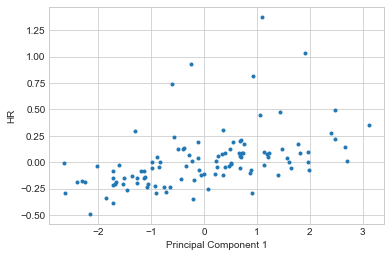

In [64]:
plt.plot(principalComponents2[:,0], data['hr'], '.')
plt.xlabel('Principal Component 1')
plt.ylabel('HR')
# plt.savefig('HRvPCA1.pdf')
plt.show()

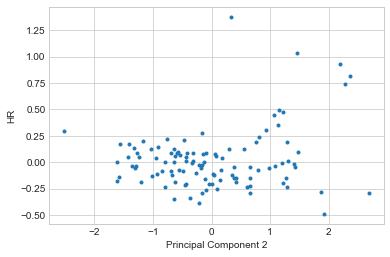

In [65]:
plt.plot(principalComponents2[:,1], data['hr'], '.')
plt.xlabel('Principal Component 2')
plt.ylabel('HR')
# plt.savefig('HRvPCA2.pdf')
plt.show()

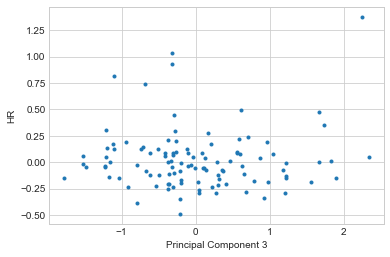

In [66]:
plt.plot(principalComponents2[:,2], data['hr'], '.')
plt.xlabel('Principal Component 3')
plt.ylabel('HR')
# plt.savefig('HRvPCA3.pdf')
plt.show()

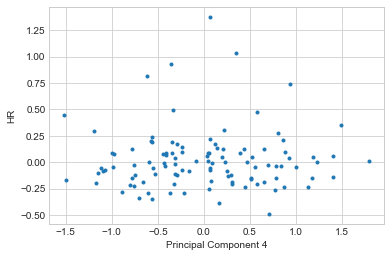

In [67]:
plt.plot(principalComponents2[:,3], data['hr'], '.')
plt.xlabel('Principal Component 4')
plt.ylabel('HR')
# plt.savefig('HRvPCA4.pdf')
plt.show()

[ 0.53352587, -0.04696966, -0.56537291, -0.62729377] of x1, color, stellar mass, and age.

* color has no effect.
* x1 shows that it is different SNIa, of our standard definitions.
* stellar mass and age have a negative correlation of almost equal weight, but age is slightly stronger.


### PCA without HR and without objects with HR < 0.5

Removes 5 objects

In [57]:
features = ['x1', 'color', 'stellar mass', 'age']
z = data[data['hr']<0.5].loc[:, features].values
z = StandardScaler().fit_transform(z)
z.shape

(103, 4)

In [58]:
pca3 = PCA(n_components=4)
principalComponents3 = pca3.fit_transform(z)

In [60]:
pca3.components_

array([[ 0.54259113, -0.10542863, -0.56066036, -0.61655465],
       [-0.16048507,  0.95949048, -0.1897051 , -0.13279506],
       [-0.73930618, -0.25248866, -0.622891  , -0.04102012],
       [ 0.36505586,  0.06717357, -0.51154544,  0.77494722]])

In [61]:
pca3.singular_values_

array([ 13.5253809 ,  10.21837964,   8.49723135,   7.2419506 ])

In [72]:
pca3.explained_variance_ratio_

array([ 0.44401924,  0.25343515,  0.17524986,  0.12729575])

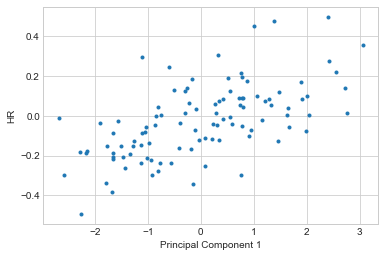

In [73]:
plt.plot(principalComponents3[:,0], data[data['hr']<0.5]['hr'], '.')
plt.xlabel('Principal Component 1')
plt.ylabel('HR')
plt.savefig('HRvPCA1.pdf')
plt.show()

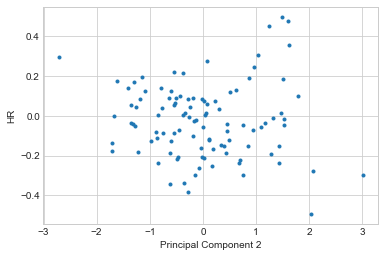

In [74]:
plt.plot(principalComponents3[:,1], data[data['hr']<0.5]['hr'], '.')
plt.xlabel('Principal Component 2')
plt.ylabel('HR')
plt.savefig('HRvPCA2.pdf')
plt.show()

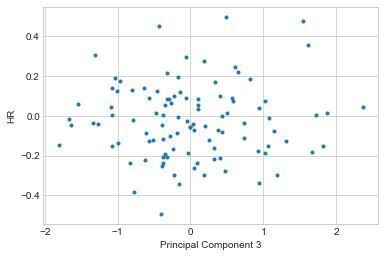

In [75]:
plt.plot(principalComponents3[:,2], data[data['hr']<0.5]['hr'], '.')
plt.xlabel('Principal Component 3')
plt.ylabel('HR')
plt.savefig('HRvPCA3.pdf')
plt.show()

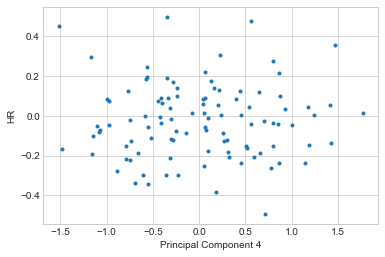

In [76]:
plt.plot(principalComponents3[:,3], data[data['hr']<0.5]['hr'], '.')
plt.xlabel('Principal Component 4')
plt.ylabel('HR')
plt.savefig('HRvPCA4.pdf')
plt.show()

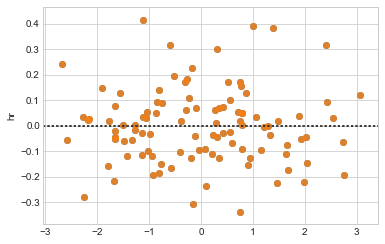

In [81]:
sns.residplot(principalComponents3[:,0], data[data['hr']<0.5]['hr'])
plt.show()